In [13]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
from navigation_mdp.plotting import *
# RL utils
import rl.planning as Plan
import rl.policy as Policy
# from rl.model import RewardLinear, RewardConvAE, RewardConvFCAE
from rl.model import ConvFCAutoEncoder, ConvAutoEncoder, RewardLinear
from irl.mlirl.mlirl import run_mlirl
# Utils
from utils.utils import *
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Satellite Image World

Note: image clipped to: (600, 800, 3)


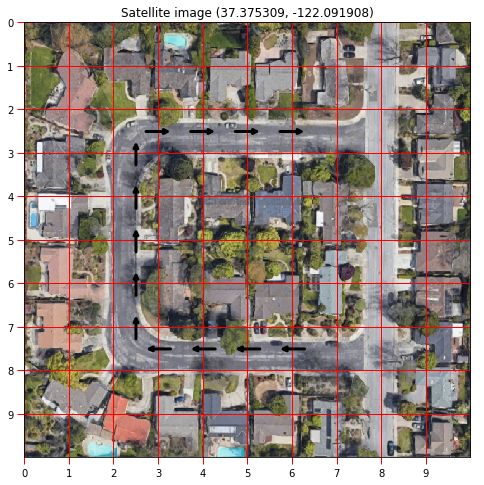

In [2]:
import cv2
import navigation_vis.Raster as NavGridView

img = cv2.imread("./Datasets/GoogleSatellite/goog_satimg_37.375309_-122.091908.png")[:,:,::-1]
img = cv2.resize(img, (800, 600))
# plt.imshow(img)
img_dtizer = NvMDP.features.ImageDiscretizer(img, 10, 10, (0,0))

# Expert demonstration
s_lst_lst = [[(7,6), (7,5), (7,4), (7,3), (7,2), 
              (6,2), (5,2), (4,2), (3,2), 
              (2,2), (2,3), (2,4), (2,5), (2,6)]]

plt.figure(figsize=(8,8))
NavGridView.Raster(img_dtizer() / 255.).render().ticks(minor=False).grid().add_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10}).title("Satellite image (37.375309, -122.091908)")

##  Setup LfD World

In [3]:
lfdw = NvMDP.world.DiscreteLfDWorld2D(
            discrete_state_space = NvMDP.state.DiscreteStateSpace(10,10),
            
            phi_spec = [],
            r_spec = [],
            class_ids = NvMDP.class_.XYClassDistribution(
                np.arange(10 * 10).reshape(10, 10).tolist())().flatten(),
    
            s_lst_lst = s_lst_lst,
            a_lst_lst = None
)

### Indicator features and linear reward

In [31]:
preprocess_fn_linear = lambda x: torch.FloatTensor(x)
postprocess_fn_linear = lambda x: x.squeeze()

lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIndicatorOneHot(key="state_ind"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model = RewardLinear(lfdw.get_feture_shape("state_ind"), lr=0.1, weight_decay=0.), 
        preprocess_fn = preprocess_fn_linear, 
        postprocess_fn = postprocess_fn_linear,
        key="state_ind_linear", feature_key="state_ind"))

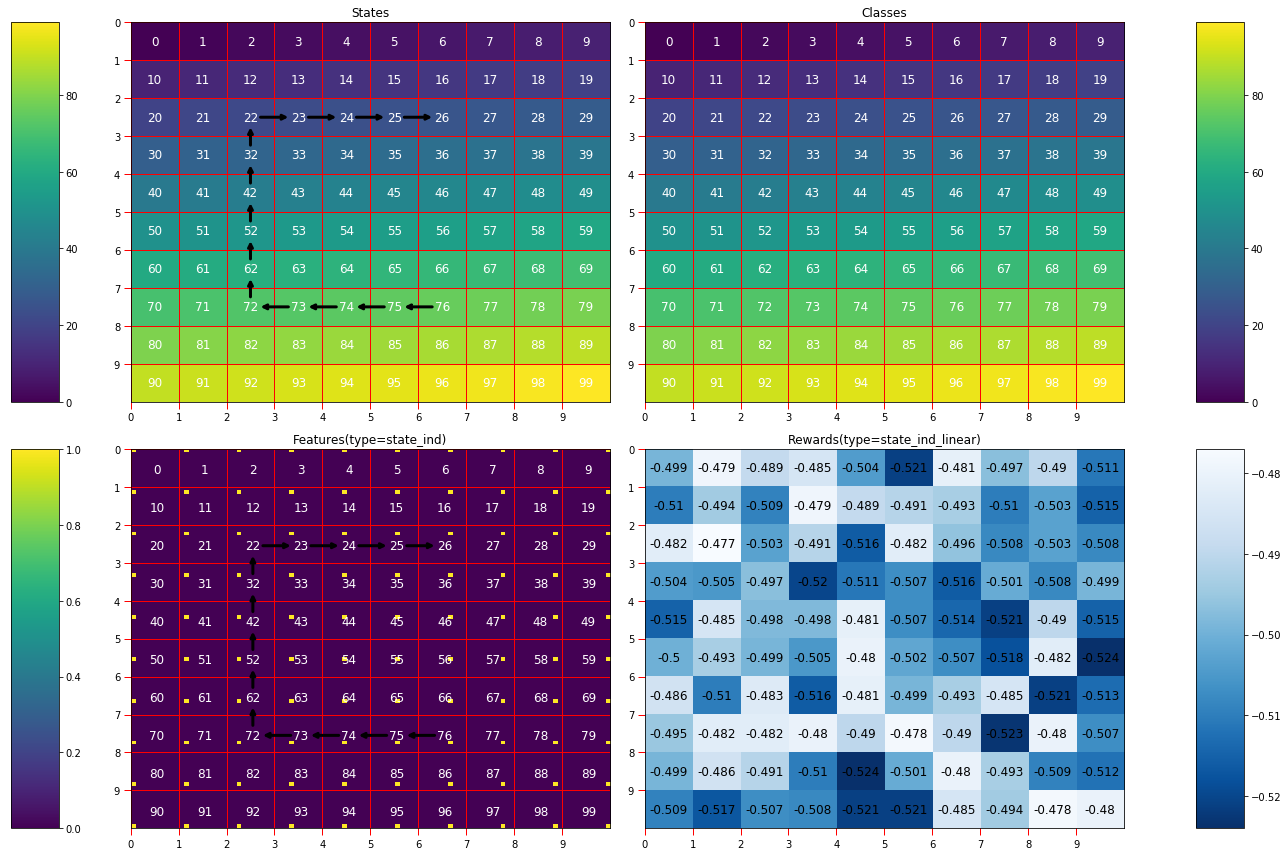

In [32]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="state_ind_linear", phi_key="state_ind")

### Image features and CNN reward

In [59]:
preprocess_fn = lambda x: torch.FloatTensor(x).unsqueeze(0).permute(0,3,1,2) \
                                        if len(torch.FloatTensor(x).shape) == 3 \
                                        else torch.FloatTensor(x).permute(0,3,1,2)
postprocess_fn = lambda x: x.squeeze()
loc_to_array_fn = lambda row, col: img_dtizer.get_image_cell(row, col)/255.

r_model_cnn_fc = ConvFCAutoEncoder(
    preprocess_fn(loc_to_array_fn(0, 0)).shape[1:], fc1_in=4800, lr=0.005, weight_decay=0.)

r_model_cnn = ConvAutoEncoder(
    preprocess_fn(loc_to_array_fn(0, 0)).shape[1:], z_dim=300, lr=0.01, weight_decay=0.)

lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateLocToArray(loc_to_array_fn, key="rgb_image"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model = r_model_cnn_fc,
        preprocess_fn = preprocess_fn, 
        postprocess_fn = postprocess_fn,
        key="CNN", feature_key="rgb_image"))

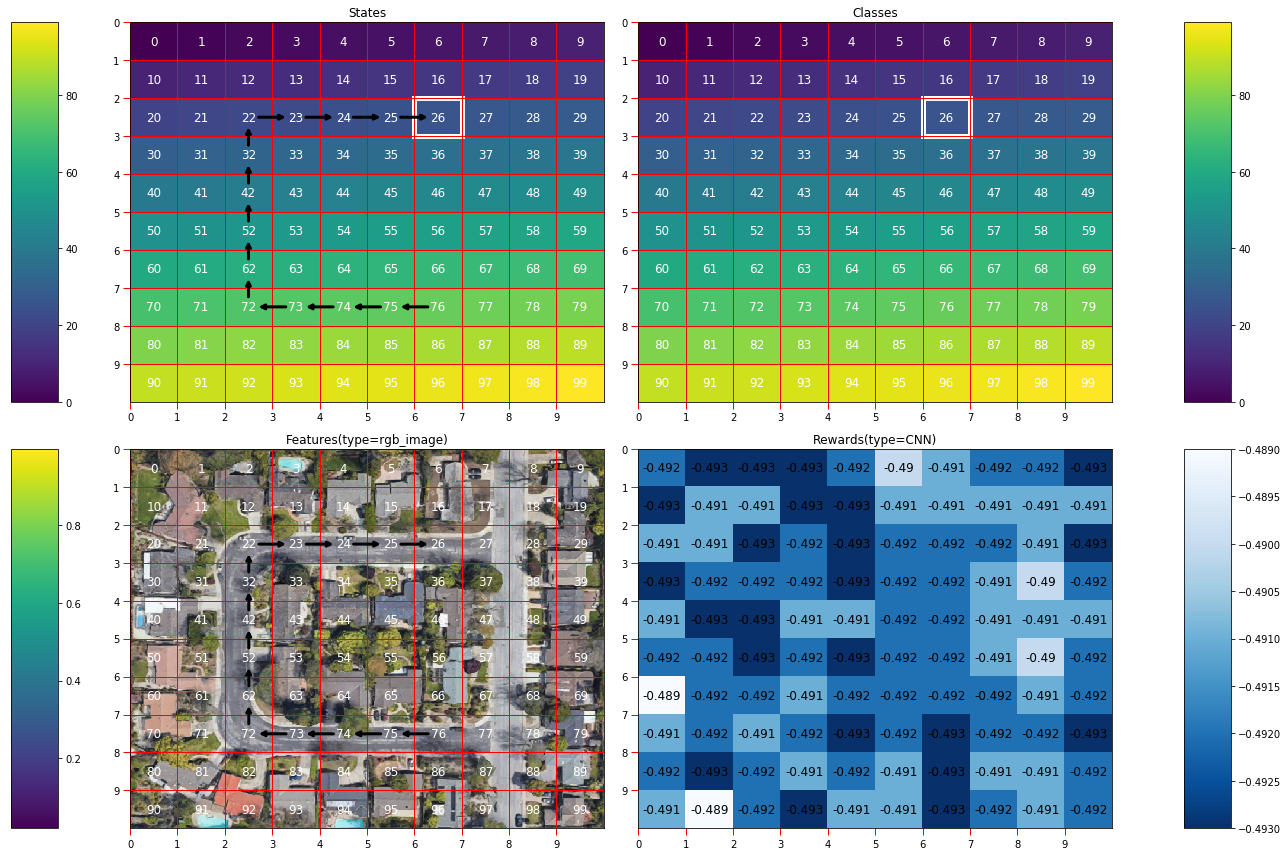

In [60]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="CNN", phi_key="rgb_image")

### PCA features and linear reward

In [37]:
from sklearn.decomposition import PCA

pca_components = 10
PHI_flatten = lfdw.features(numpyize=True, key="rgb_image").reshape(len(lfdw.S), -1)
pca = PCA(n_components=pca_components)
pca.fit(PHI_flatten)
PHI_pca = pca.transform(PHI_flatten).reshape(len(lfdw.S), -1)

In [38]:
r_model_pca_linear = RewardLinear(pca_components, lr=0.1, weight_decay=0.)
lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIdxToArray(lambda idx: PHI_pca[idx], key="rgb_image_pca"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model_pca_linear, preprocess_fn=preprocess_fn_linear,
        postprocess_fn=postprocess_fn_linear, 
        key="pca_linear", feature_key="rgb_image_pca"))

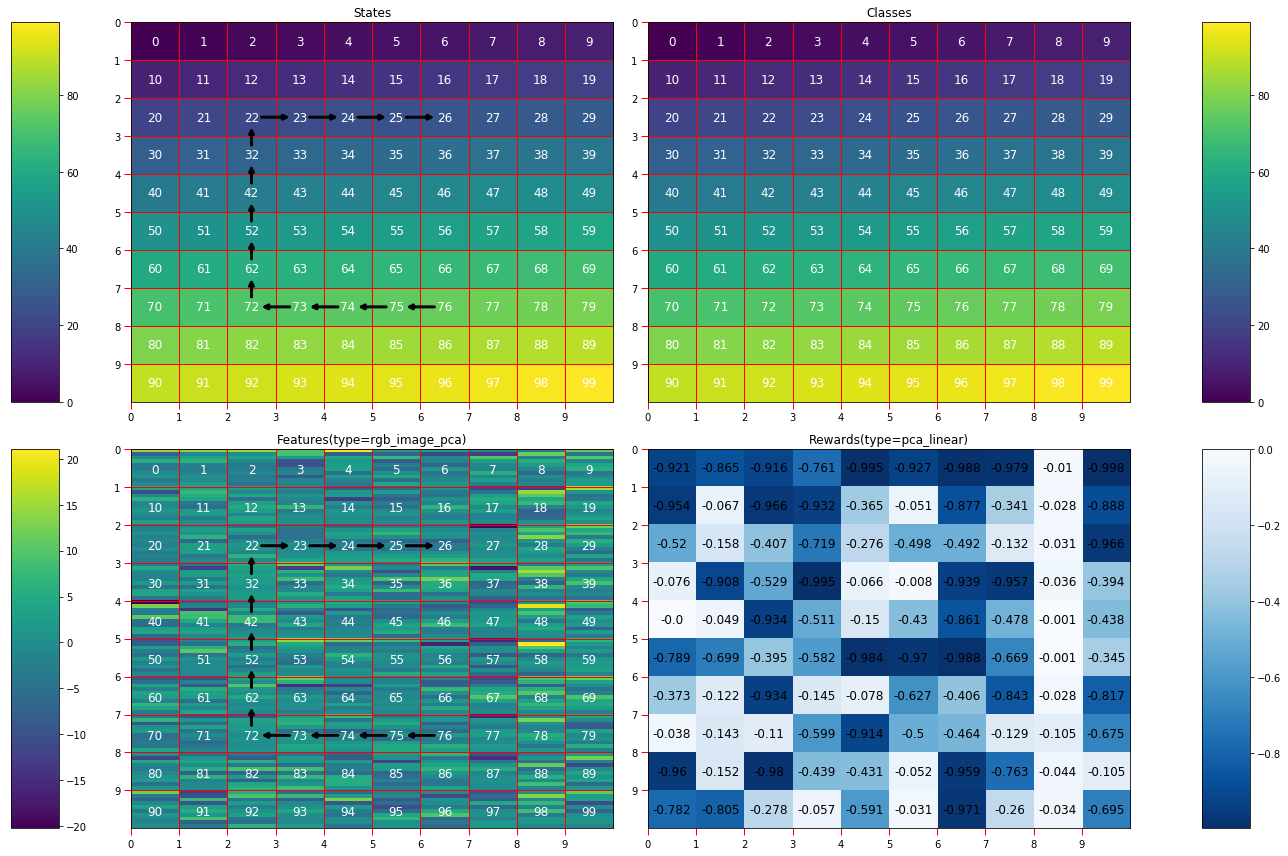

In [39]:
plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="pca_linear", phi_key="rgb_image_pca")

### RGB + CNN

In [61]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn(lfdw.features(numpyize=False, key="rgb_image")), 
    T = lfdw.dynamics(),
    R_model = r_model_cnn,
    gamma=0.95,
    mlirl_iters = 100,
    vi_max_iters = 150,
    reasoning_iters = 50,
    boltzmann_temp = 0.1,
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 19.
Reasoning [  19 49 68 ] Done (50 iters).
>>> Iter: 0000 (2.952s): loss = 31.965218, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 20.
Reasoning [  20 50 69 ] Done (50 iters).
>>> Iter: 0001 (3.076s): loss = 26.679976, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
Training interrupted @ iter 2


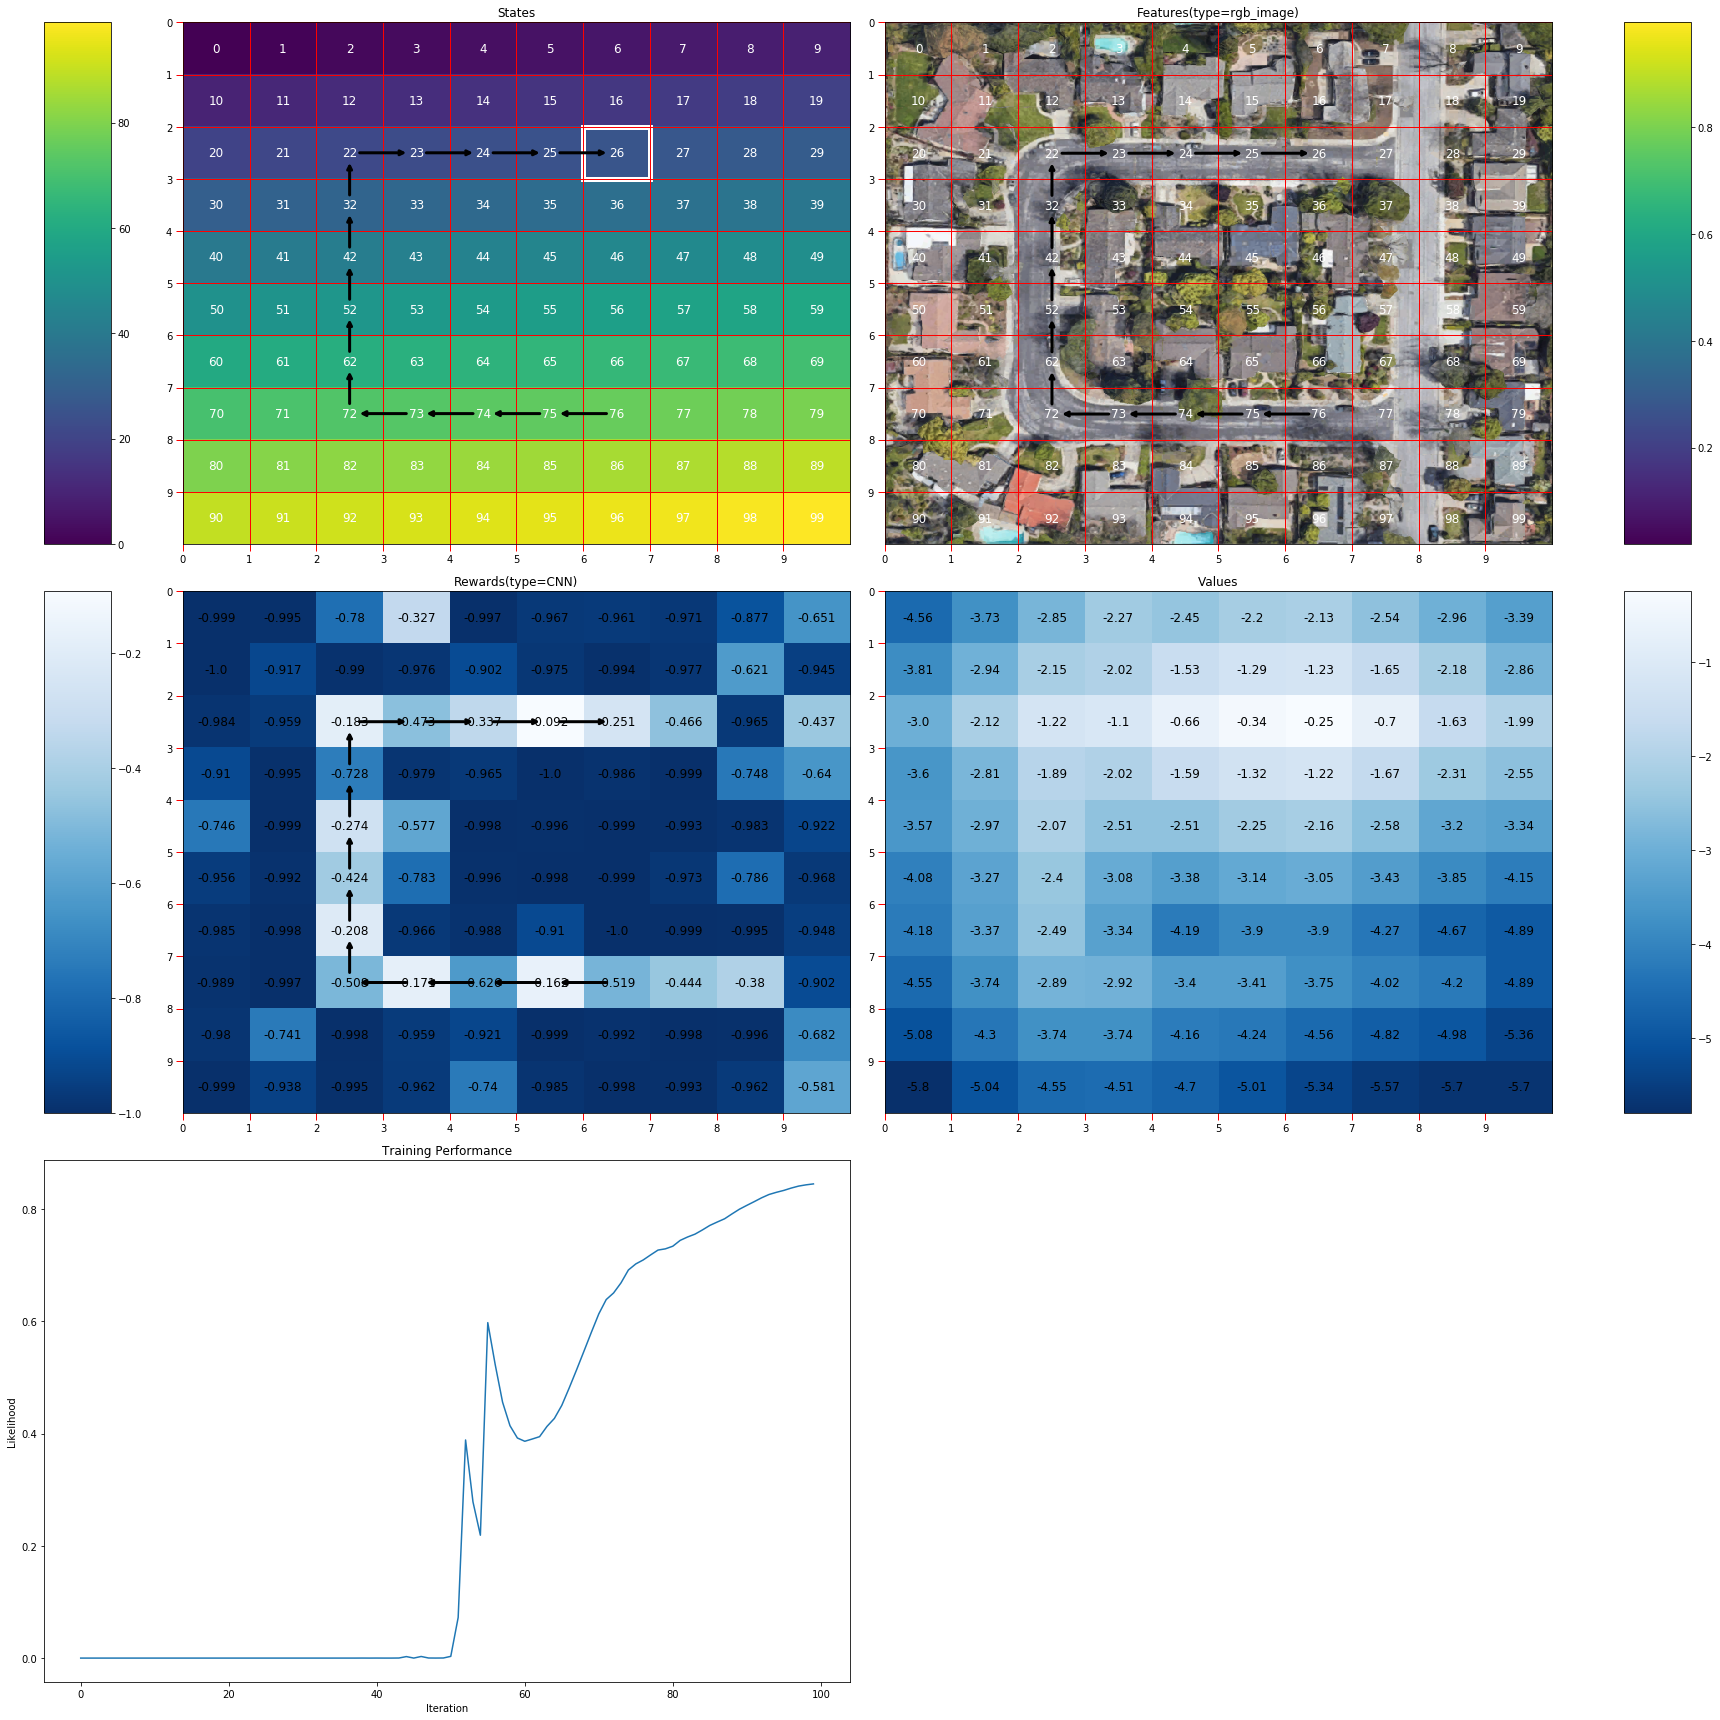

In [58]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="CNN", phi_key="rgb_image")
plt.savefig("./figures/mlirl_gridworld_10x10_cnn__traj_2_turns")

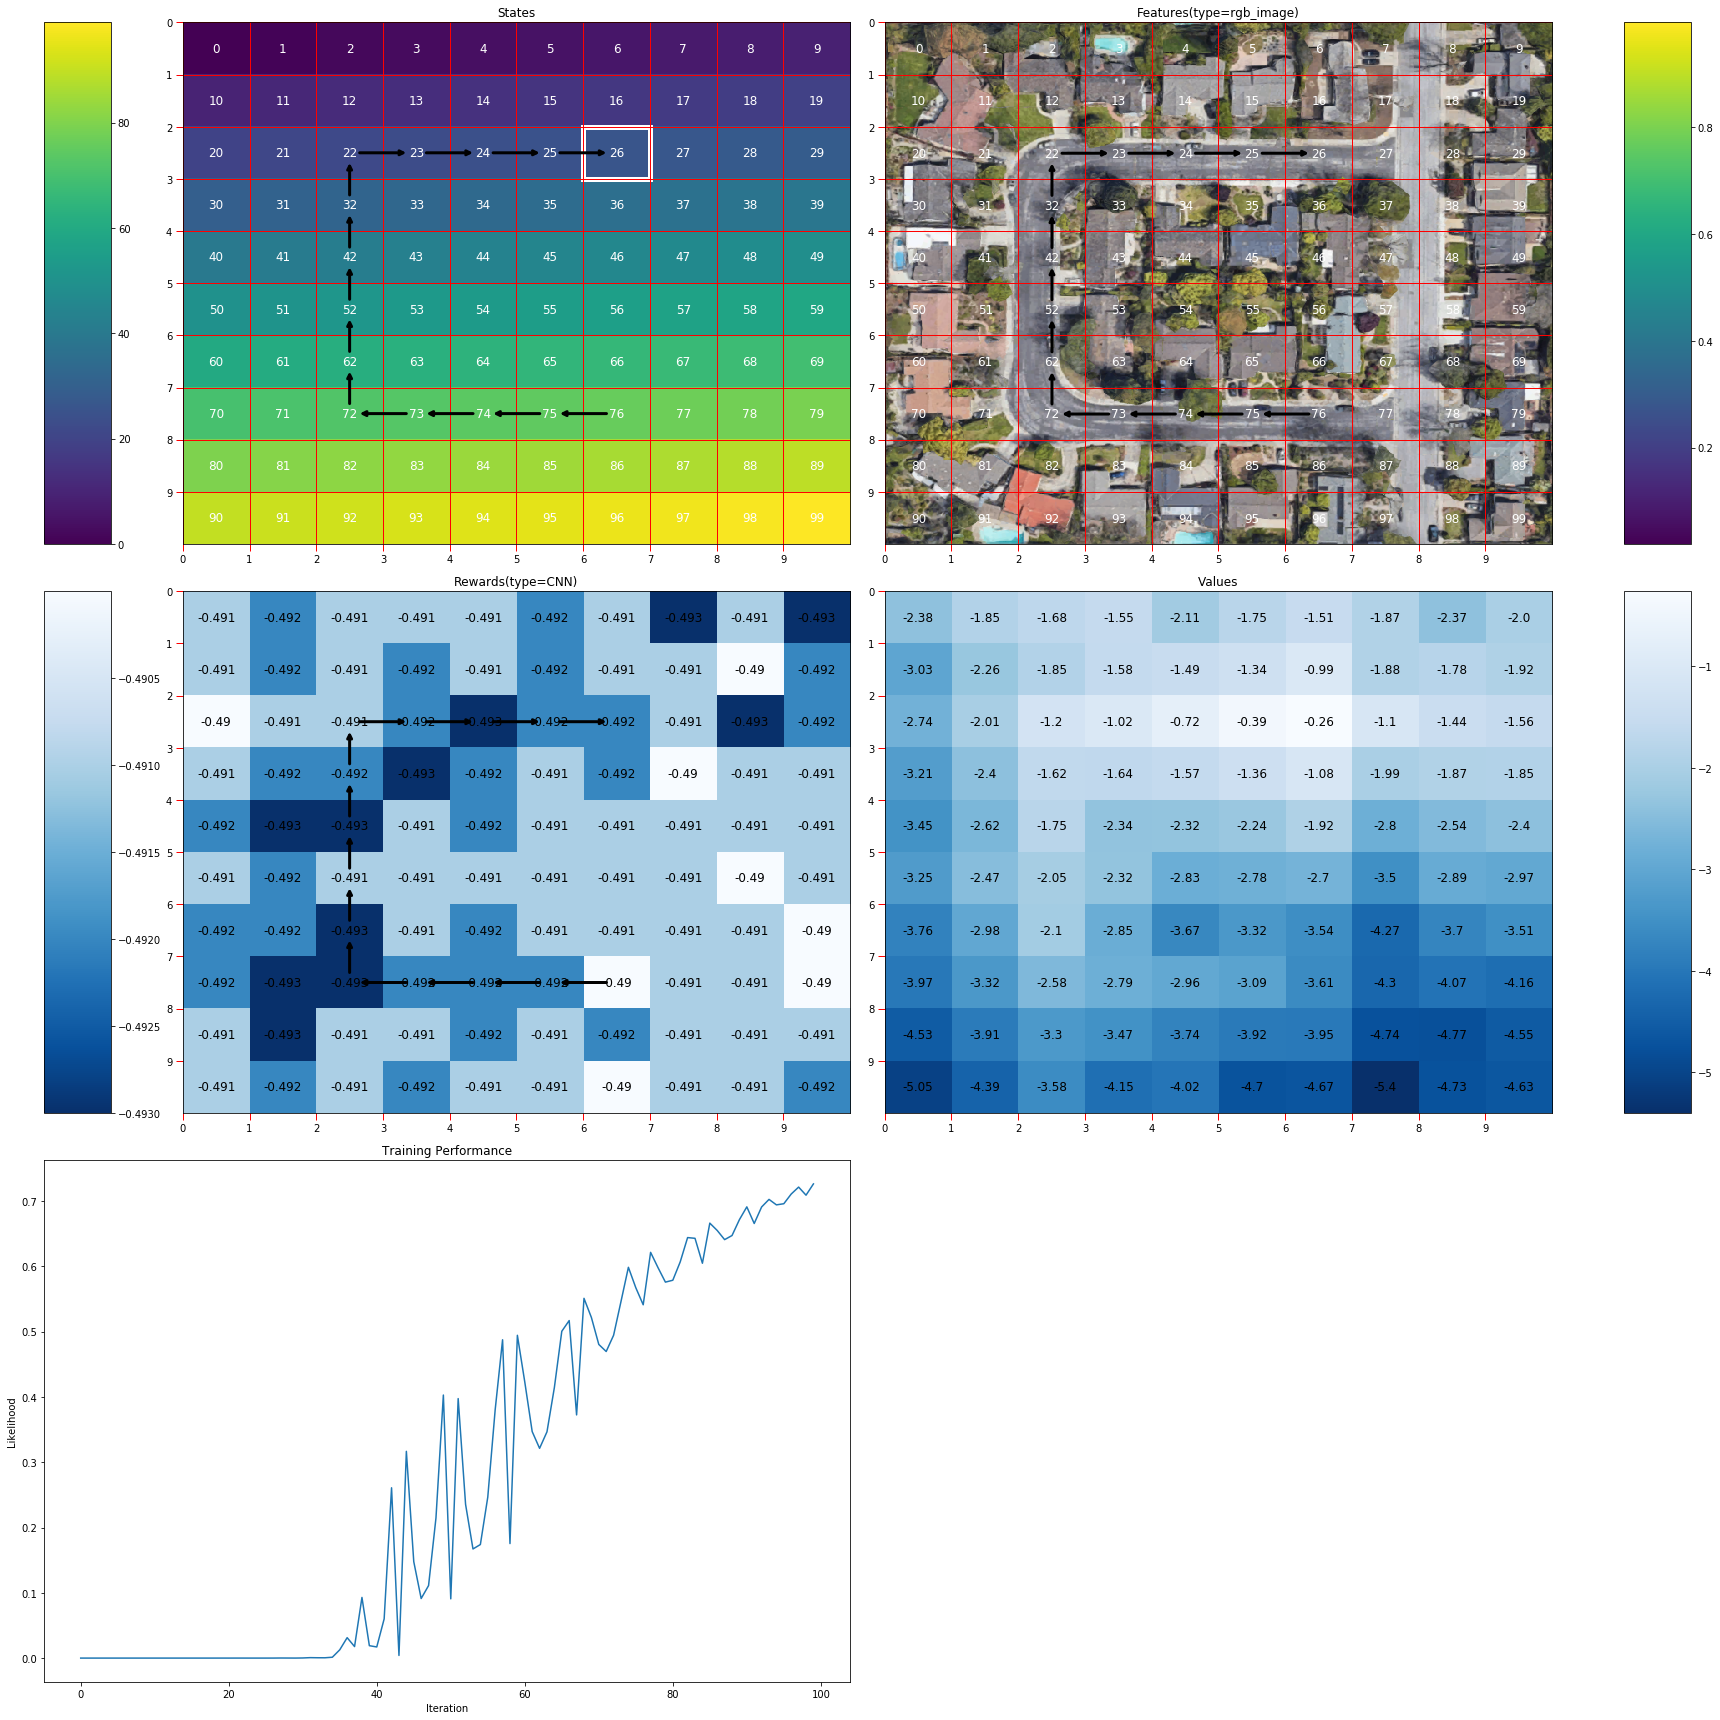

In [10]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="CNN", phi_key="rgb_image")
plt.savefig("./figures/mlirl_gridworld_10x10_cnn__traj_2_turns")

## Ind + Linear

In [62]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn_linear(lfdw.features(numpyize=False, key="state_ind")),
    T = lfdw.dynamics(),
    R_model = lfdw.get_reward_model("state_ind_linear"),
    gamma=0.95,
    mlirl_iters = 100,
    vi_max_iters = 150,
    reasoning_iters = 50,
    boltzmann_temp = 0.01,
    vi_eps=1e-6
)

Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 15.
Reasoning [  15 45 64 ] Done (50 iters).
>>> Iter: 0000 (2.784s): loss = 258.593842, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 14.
Reasoning [  14 44 63 ] Done (50 iters).
>>> Iter: 0001 (3.025s): loss = 224.421066, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 14.
Reasoning [  14 44 63 ] Done (50 iters).
>>> Iter: 0002 (2.973s): loss = 190.500443, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 13.
Reasoning [  13 43 62 ] Done (50 iters).
>>> Iter: 0003 (2.988s): loss = 157.991837, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 12.
Reasoning [  12 42 61 ] Done (50 iters).
>>> Iter: 0004 (2.875s): loss = 126.086105, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 ] Converged @ 12.
Reasoning [  12 42 61 ] Done (50 iters).
>>> Iter: 0005 (2.956s): loss = 95

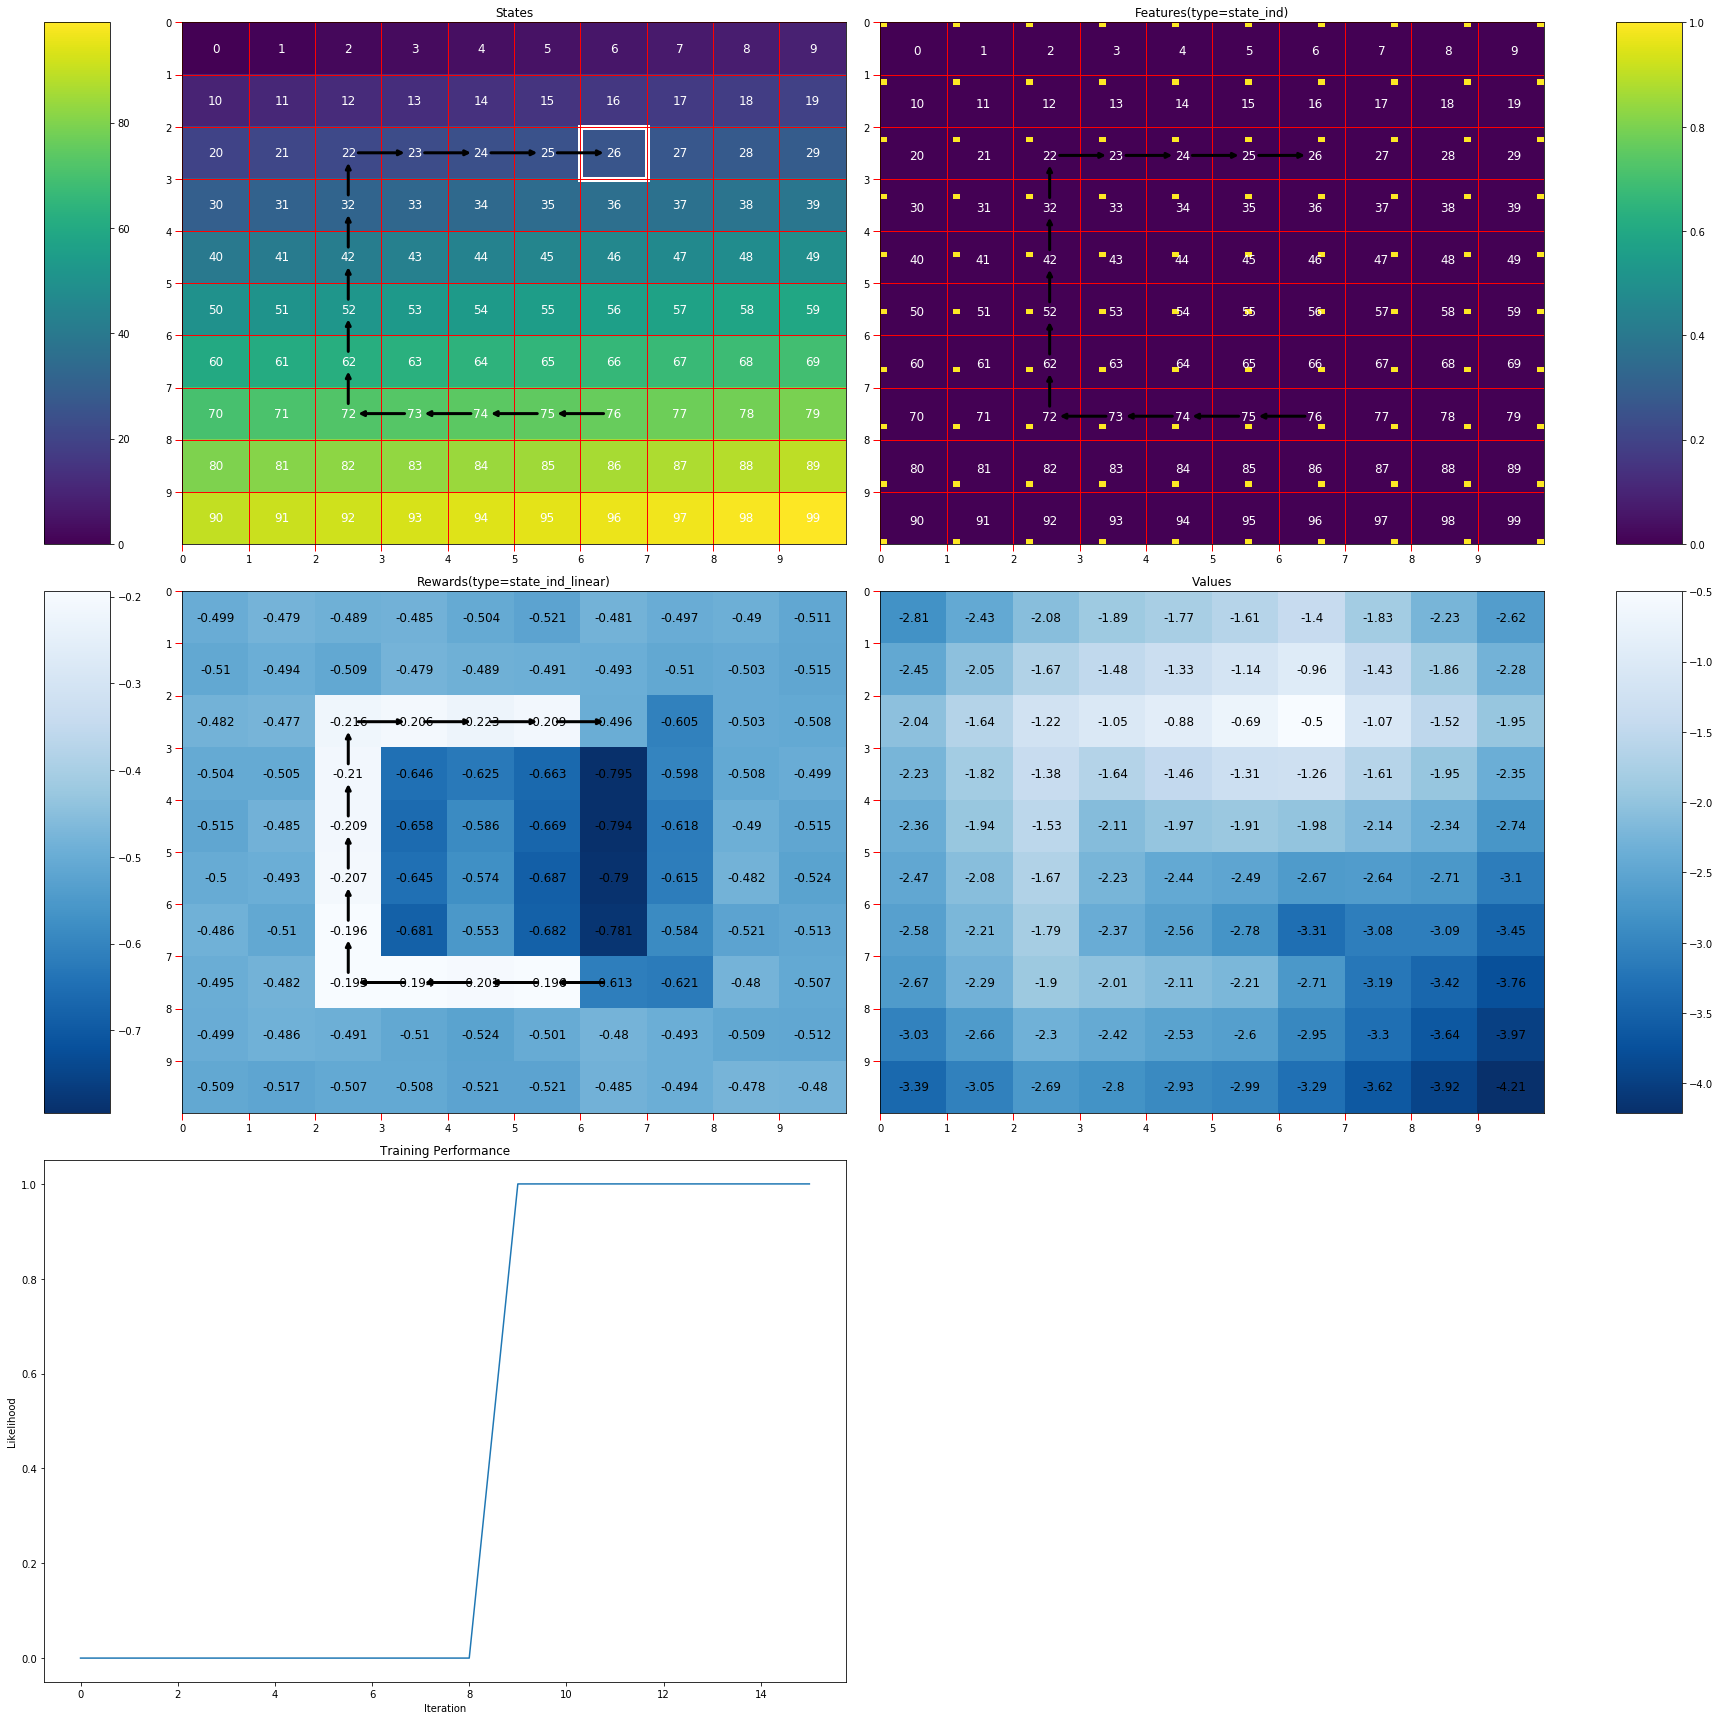

In [63]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="state_ind_linear", phi_key="state_ind")
plt.savefig("./figures/mlirl_gridworld_10x10_one_hot__traj_2_turns")

In [16]:
np.save("./data/mlirl_gridworld_10x10_one_hot__traj_2_turns__rewards.npy", R_curr.detach().numpy())

### PCA + Linear

In [47]:
pca_components = 100
PHI_flatten = lfdw.features(numpyize=True, key="rgb_image").reshape(len(lfdw.S), -1)
pca = PCA(n_components=pca_components)
pca.fit(PHI_flatten)
PHI_pca = pca.transform(PHI_flatten).reshape(len(lfdw.S), -1)

r_model_pca_linear = RewardLinear(pca_components, lr=0.01, weight_decay=0.)
lfdw.attach_feature_spec(
    NvMDP.features.FeatureStateIdxToArray(lambda idx: PHI_pca[idx], key="rgb_image_pca"))
lfdw.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model_pca_linear, preprocess_fn=preprocess_fn_linear,
        postprocess_fn=postprocess_fn_linear, 
        key="pca_linear", feature_key="rgb_image_pca"))

In [48]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    tau_lst = lfdw.trajectories(s_a_zipped=True),
    S = lfdw.S,
    PHI = preprocess_fn_linear(lfdw.features(numpyize=False, key="rgb_image_pca")),
    T = lfdw.dynamics(),
    R_model = r_model_pca_linear,
    gamma=0.99,
    mlirl_iters = 100,
    vi_max_iters = 200,
    reasoning_iters = 50,
    boltzmann_temp = 0.1,
    vi_eps=1e-4
)

Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0000 (4.484s): loss = 58.916126, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 70.
Reasoning [  70 100 119 ] Done (50 iters).
>>> Iter: 0001 (4.610s): loss = 47.637486, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0002 (4.609s): loss = 36.293880, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 68.
Reasoning [  68 98 117 ] Done (50 iters).
>>> Iter: 0003 (4.547s): loss = 25.428812, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 69.
Reasoning [  69 99 118 ] Done (50 iters).
>>> Iter: 0004 (4.593s): loss = 15.722516, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0 30 60 ] Converged @ 73.
Reasoning [  73 103 122 ] Done (50 ite

>>> Iter: 0045 (6.618s): loss = 01.304404, likelihood = 0.2713


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 124.
Reasoning [  124 154 173 ] Done (50 iters).
>>> Iter: 0046 (7.979s): loss = 01.268801, likelihood = 0.2812


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 127.
Reasoning [  127 157 176 ] Done (50 iters).
>>> Iter: 0047 (6.950s): loss = 01.238281, likelihood = 0.2899


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 130.
Reasoning [  130 160 179 ] Done (50 iters).
>>> Iter: 0048 (7.085s): loss = 01.213401, likelihood = 0.2972


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 131.
Reasoning [  131 161 180 ] Done (50 iters).
>>> Iter: 0049 (7.150s): loss = 01.193220, likelihood = 0.3032


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 120 ] Converged @ 133.
Reasoning [  133 163 182 ] Done (50 iters).
>>> Iter: 0050 (7.181s): loss = 01.173486, likelihood = 0.30

Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0090 (6.355s): loss = 00.198354, likelihood = 0.8201


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0091 (6.084s): loss = 00.189529, likelihood = 0.8273


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 114.
Reasoning [  114 144 163 ] Done (50 iters).
>>> Iter: 0092 (6.070s): loss = 00.181791, likelihood = 0.8338


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reasoning [  115 145 164 ] Done (50 iters).
>>> Iter: 0093 (6.273s): loss = 00.175019, likelihood = 0.8394


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reasoning [  115 145 164 ] Done (50 iters).
>>> Iter: 0094 (6.892s): loss = 00.169104, likelihood = 0.8444


Running VI (goal: (2, 6))
Learning values [  0 30 60 90 ] Converged @ 115.
Reaso

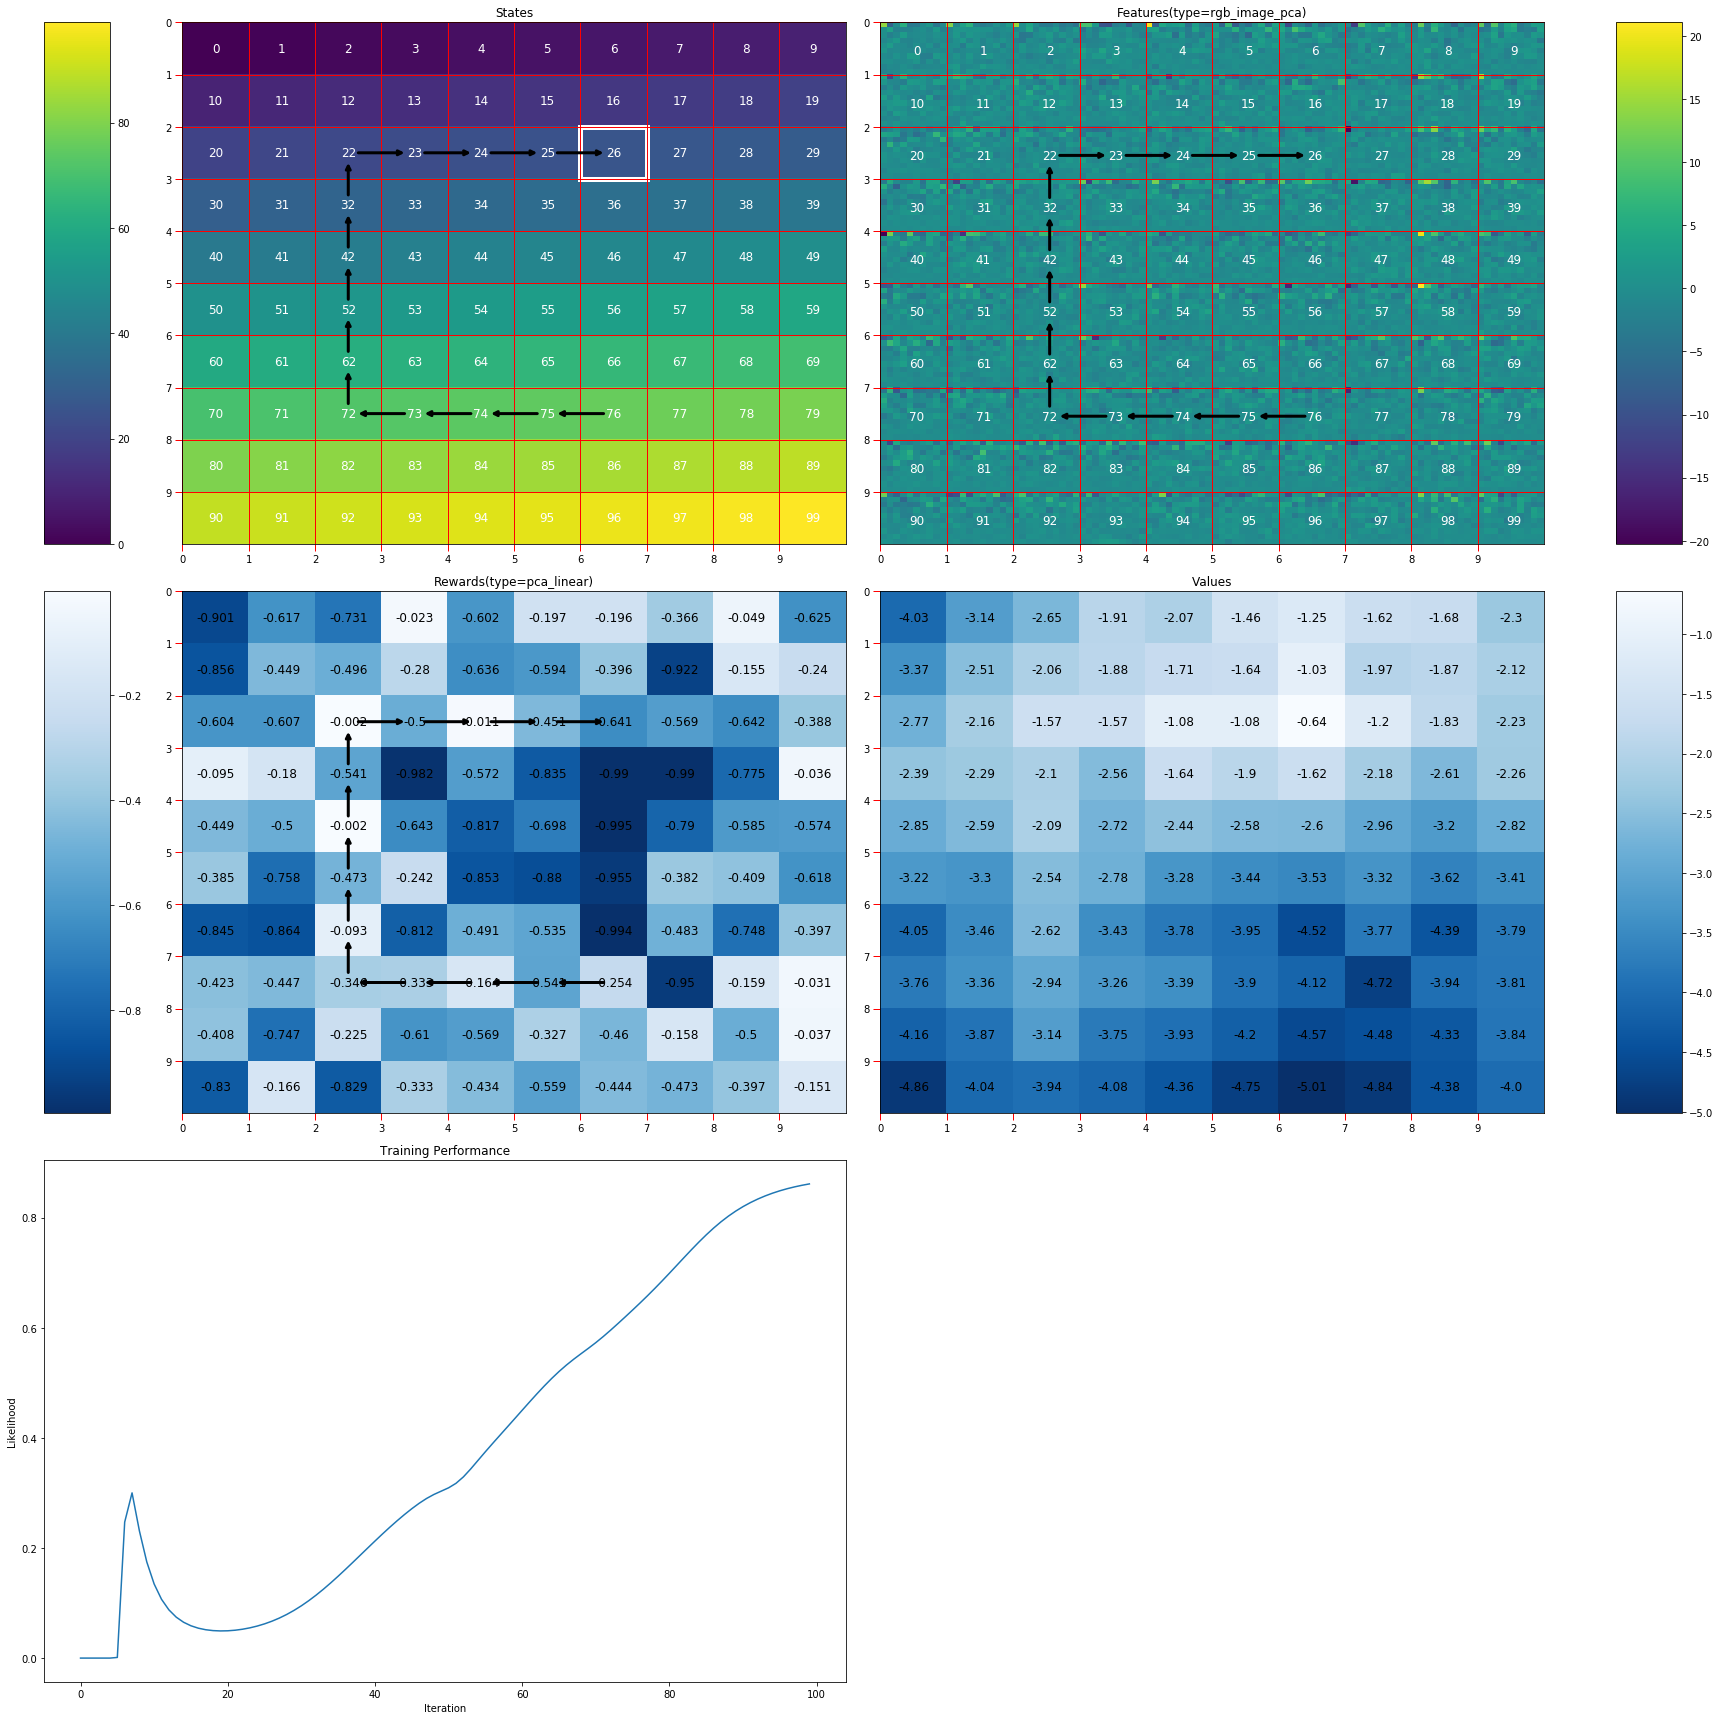

In [49]:
VI = VI_by_goal[s_lst_lst[0][-1]]
plot_irl_results(lfdw.S, lfdw.trajectories()[0], 
               VI.V.detach().numpy().round(2),
               log_likelihoods_history, r_key="pca_linear", phi_key="rgb_image_pca")
plt.savefig("./figures/mlirl_gridworld_10x10_pca__traj_2_turns")

### Autonencoder + Linear